In [4]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy import signal

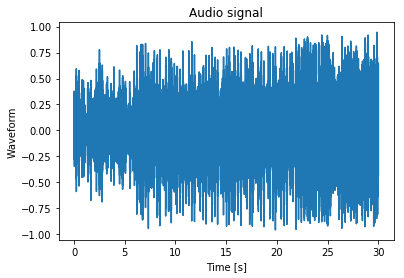

In [5]:
#path = "Data/genres_original/country/country.00097.wav"
path = "Data/genres_original/pop/pop.00009.wav"
# n_fft = 2048
# hop_length = 512
sample, sr = librosa.load(path)
duration = np.arange(len(sample)) / sr

plt.plot(duration, sample)
plt.title("Audio signal")
plt.ylabel("Waveform")
plt.xlabel("Time [s]")
plt.show()
ipd.Audio(sample, rate=sr)

In [12]:
tempo, beats = librosa.beat.beat_track(y=sample, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)
print(beat_times)
clicks = librosa.clicks(beat_times, sr=sr, length=len(sample))
ipd.Audio(sample + clicks, rate=sr)

[ 0.510839    1.11455782  1.67183673  2.2523356   2.80961451  3.39011338
  3.94739229  4.5046712   5.08517007  5.66566893  6.22294785  6.80344671
  7.36072562  7.94122449  8.4985034   9.07900227  9.63628118 10.21678005
 10.77405896 11.35455782 11.91183673 12.4923356  13.04961451 13.63011338
 14.18739229 14.76789116 15.32517007 15.92888889 16.4861678  17.06666667
 17.62394558 18.20444444 18.76172336 19.34222222 19.89950113 20.48
 21.03727891 21.61777778 22.17505669 22.75555556 23.31283447 23.89333333
 24.45061224 25.03111111 25.58839002 26.16888889 26.7261678  27.30666667
 27.86394558 28.44444444]


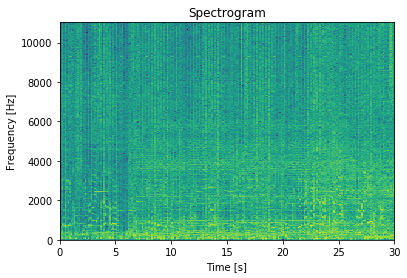

(1537, 217)


In [7]:
# %% Calculate beat duration
beatDurationSec = 60 / tempo
quarterBeat = beatDurationSec / 4
beatDurationSample = int(beatDurationSec * sr)

# win_length = sr * 0.0226  #frame length of 22.6ms
# win_length = int(win_length)
# hop_length = beatDurationSample//2
# # %% target spectrogram
spectrogram, frequencies, times, im = plt.specgram(
    sample,
    Fs=sr,
    NFFT=int(beatDurationSample / 4),
    noverlap=int(beatDurationSample / 512),
    mode="magnitude",
)
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()
print(spectrogram.shape)

In [8]:
lenTimes = len(times)
lenBeatTimes = len(beat_times)
beats = []
frequency_beats = []
  
for i in range(lenBeatTimes-1):
    beats.append([])
    for j in range(lenTimes):
        if times[j] >= beat_times[i] and times[j] < beat_times[i + 1]:
            beats[i].append(times[j])
           
        
min_frames_in_this_song = min(map(len, beats))
# min_frames_in_this_song = 2


for i in range(lenBeatTimes):
    frequency_beats.append([])
            
for i in range(lenBeatTimes-1):
    frames = 0
    for j in range(lenTimes):
        if times[j] >= beat_times[i] and times[j] < beat_times[i + 1] and frames < min_frames_in_this_song:
            frequency_beats[i].append(spectrogram[j])
            frames += 1

# for i in range(lenBeatTimes-1):
#     frames = 0
#     for j in range(lenTimes-1):
#         if times[j] >= beat_times[i] and  times[j] < max(beat_times[i + 1],times[j-1], times[j+1])  and frames < min_frames_in_this_song:
#             frequency_beats[i].append(spectrogram[j])
#             frames += 1
# # print(frequency_beats)

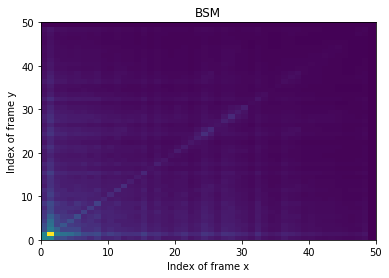

In [9]:
bsm = np.zeros((lenBeatTimes, lenBeatTimes))
for i in range(lenBeatTimes-1):
    for j in range(lenBeatTimes-1):
        for k in range(min_frames_in_this_song):
            bsm[i,j] += np.sum(frequency_beats[i][k] * frequency_beats[j][k])
            
plt.pcolormesh(bsm)
plt.title("BSM")
plt.xlabel("Index of frame x")
plt.ylabel("Index of frame y")
plt.show()

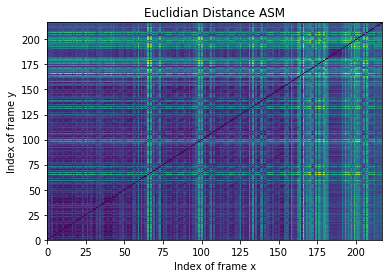

In [11]:
binsAmount = len(times)
asm = np.zeros((binsAmount, binsAmount))
# bsm = np.zeros((binsAmount, binsAmount))


def euclidianDistance(oneBin, secondBin):
    return np.sum(np.square(oneBin - secondBin)), "Euclidian Distance"

def cosineDistance(oneBin, secondBin):
    return (
        1
        - np.sum(np.square(oneBin * secondBin))
        / (np.sqrt(np.sum(np.square(oneBin))) * np.sqrt(sum(np.square(secondBin)))),
        "Cosine Distance",
    )

def kullbackLeibler(oneBin, secondBin):
    return np.sum(oneBin * np.log(oneBin / secondBin)), "Kullback-Leiber"


for x in range(binsAmount):
    thisBin = spectrogram[:, x]
    for y in range(binsAmount):
        comparedBin = spectrogram[:, y]
        asm[x, y], method = euclidianDistance(thisBin, comparedBin)
        #asm[x, y], method = cosineDistance(thisBin, comparedBin)
        #asm[x, y], method = kullbackLeibler(thisBin, comparedBin)
#         asm[x, y] = asm[x, y] + np.min([asm[x-1, y-1], asm[x-1, y], asm[x, y-1]])

# for x in range(binsAmount):
#     thisBin = frequency_beats[x]
#     for y in range(binsAmount):
#         comparedBin = frequency_beats[y]
#         bsm[x, y], method = euclidianDistance(thisBin, comparedBin)
#         #asm[x, y], method = cosineDistance(thisBin, comparedBin)
#         #asm[x, y], method = kullbackLeibler(thisBin, comparedBin)        
        
plt.pcolormesh(asm)
plt.title(f"{method} ASM")
plt.xlabel("Index of frame x")
plt.ylabel("Index of frame y")
plt.show()

# plt.pcolormesh(bsm)
# plt.title(f"{method} BSM")
# plt.xlabel("Index of frame x")
# plt.ylabel("Index of frame y")
# plt.show()

# print(bsm)

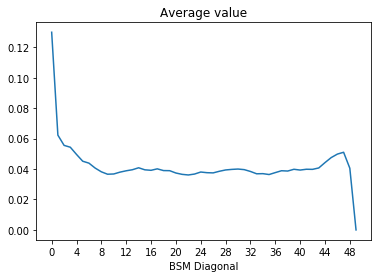

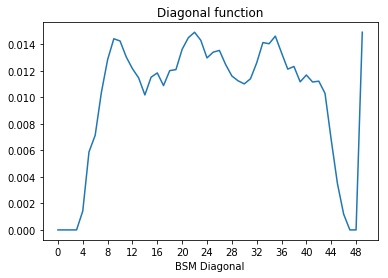

In [290]:
diagonalasNumber = len(bsm)
d = np.zeros(diagonalasNumber)
for i in range(diagonalasNumber):
    d[i] = np.average(np.diag(bsm, i))

plt.title("Average value")
plt.xlabel("BSM Diagonal")
plt.plot(d)
plt.xticks(range(0, len(d), 4))
plt.show()

# %% Calculate second function d
for i in range(diagonalasNumber):
    d[i] = -d[i] + np.max(np.abs(d))

plt.title("Diagonal function")
plt.xlabel("BSM Diagonal")
plt.plot(d)
plt.xticks(range(0, len(d), 4))
plt.show()

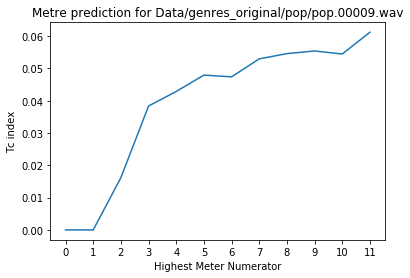

Time signature is: 11


In [291]:
highestMeterNumerator = 12
lt = int(len(bsm) / highestMeterNumerator)
t = np.zeros(highestMeterNumerator)
for c in range(2, highestMeterNumerator, 1):
    for p in range(1, lt, 1):
        t[c] += (d[p * c]) / (1 - ((p - 1) / lt))

t[0] = 0
t[1] = 0
plt.plot(t)
plt.xlabel("Highest Meter Numerator")
plt.ylabel("Tc index")
plt.title(f"Metre prediction for {path}")
plt.xticks(range(0, len(t), 1))
plt.show()

# t[0] = 0
# t[1] = 0
# plt.plot(t)
# plt.xlabel("Metre candidate")
# plt.ylabel("Tc index")
# plt.title(f"Metre prediction for {song.path.split('/')[2]}. Expected: {song.metre}")
# plt.xticks(range(0, len(t), 1))
# plt.show()

# %% detect metre
metre = np.argmax(t)
print('Time signature is:', metre)